In [2]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from .utils import PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
from river.models.utils import *
from river.data.utils import *

import river.data
from river.data.datagenerator import DataGeneratorBilbyFD
#from river.data.dataset import #DatasetStrainFD, #DatasetStrainFDFromPreCalSVDWF
#import river.data.utils as datautils
from river.data.utils import *
from river.data.reparameterize import *

from river.models import embedding
from river.models.utils import *
#from river.models.embedding.pca import project_strain_data_FDAPhi
from river.models.embedding.conv import EmbeddingConv1D, EmbeddingConv2D
from river.models.embedding.mlp import EmbeddingMLP1D

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import numpy as np
import bilby 
import pycbc 
import sys
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

import pickle
#from sklearn.utils.extmath import randomized_svd
import sklearn
from sklearn.decomposition import IncrementalPCA, randomized_svd, KernelPCA
import sklearn.decomposition 

import glob
import time

In [ ]:
torch.fft.ifft?

In [3]:
!pwd

/home/qian.hu/mlpe/river/test


In [4]:
validfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/valid'
trainfolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin_lb/train'
#noisefolder = '/home/qian.hu/mlpe/training_data/bns_50Hz1024Hz32s_lowspin/noise/design'

valid_filenames = glob.glob(f"{validfolder}/batch*/*.h5")
train_filenames = glob.glob(f"{trainfolder}/batch*/*.h5")
#noise_filenames_H1 = glob.glob(f"{noisefolder}/H1/batch*/*.pickle")
#noise_filenames_L1 = glob.glob(f"{noisefolder}/L1/batch*/*.pickle")
#noise_filenames_V1 = glob.glob(f"{noisefolder}/V1/batch*/*.pickle")

In [5]:
len(train_filenames)

64

In [6]:
def loadVandVh(Vhfilepath, Nbasis):
    with open(Vhfilepath, 'rb') as f:
        Vh = pickle.load(f)
    if len(Vh)<Nbasis:
        raise ValueError(f'required Nbasis ({Nbasis}) > len(Vh) ({len(Vh)})!')
    Vh = Vh[:Nbasis]
    V = Vh.T.conj()
        
    return V, Vh

In [7]:
V,Vh = loadVandVh("/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle", 512)

In [8]:
Vh.shape

(512, 31169)

In [9]:
source_type = 'BNS'
detector_names = ['H1', 'L1', 'V1'] 
duration = 32
f_low = 50
f_high = 1024

f_ref = 20
sampling_frequency = 2048
waveform_approximant = 'IMRPhenomPv2_NRTidal'
parameter_names = PARAMETER_NAMES_ALL_PRECESSINGBNS_BILBY
PSD_type = 'bilby_default' #'zero_noise' bilby_default
use_sealgw_detector = True

Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle"

data_generator = DataGeneratorBilbyFD(source_type,
            detector_names, 
            duration, 
            f_low, 
            f_ref, 
            sampling_frequency, 
            waveform_approximant, 
            parameter_names,
            PSD_type=PSD_type,
            use_sealgw_detector=use_sealgw_detector,
            f_high=f_high)


03:17 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Using bilby_default PSDs to generate data.


In [9]:
farray = data_generator.frequency_array_masked
ifos = data_generator.ifos
det = ifos[0]
psd = det.power_spectral_density_array[data_generator.frequency_mask]

In [263]:
%time det.time_delay_from_geocenter(1,1,1)

CPU times: user 28 µs, sys: 1e+03 ns, total: 29 µs
Wall time: 32.9 µs


-0.015369633335574994

# IFT

In [100]:
torch.fft.ifft?

In [63]:

noise_r = torch.randn((1,V.shape[0]))
noise_i = torch.randn((1,V.shape[0]))

In [64]:
noise_r.shape

torch.Size([1, 31169])

In [71]:
V[:,0].shape

(31169,)

In [101]:
noise_td = torch.fft.ifft((noise_r + 1j*noise_i)*V[:,0], norm='forward')

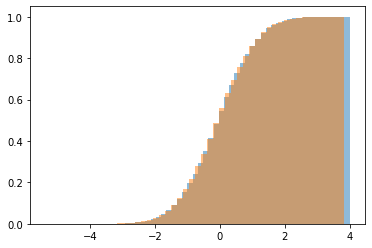

In [102]:
_ = plt.hist(noise_td.real[0].detach().numpy() , density=True, alpha=0.5, bins=50, cumulative=True)
_ = plt.hist(noise_r[0].detach().numpy(), density=True, alpha=0.5, bins=50, cumulative=True)


In [10]:
dataset_test = DatasetConvStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, add_noise=False, shuffle=False, fix_extrinsic=False)


NameError: name 'DatasetConvStrainFDFromSVDWFonGPU' is not defined

In [ ]:
index_of_file, index_in_file = (0, 54)
wf_dict = dataset_test.get_precalwf_dict(index_of_file)
hp_svd, hc_svd = dataset_test.get_waveform_tensors(wf_dict, index_in_file)

injection_parameters = dataset_test.get_injection_parameters(wf_dict,index_in_file)
injection_parameters = dataset_test.update_injection_parameters(injection_parameters)
hp_svd = hp_svd/injection_parameters['luminosity_distance']
hc_svd = hc_svd/injection_parameters['luminosity_distance']
#x_real, x_imag = self.compute_strain_tensors(hp_svd, hc_svd, injection_parameters)

theta = dataset_test.get_theta(injection_parameters)

In [188]:
injection_parameters['luminosity_distance']

12.009739273309345

In [189]:
injection_parameters['geocent_time'] = 1231231

In [223]:
num_ifos = 3
width = 4096
x = torch.zeros((num_ifos, dataset_test.Nbasis), dtype=torch.complex64, device=dataset_test.device)
for i, det in enumerate(dataset_test.ifos):
    detname = det.name

    fp, fc, dt = dataset_test.compute_detector_factors(det, injection_parameters)
    phase2add = torch.exp(-1j * 2 * np.pi * dt * dataset_test.farray)
    Vh_recons = dataset_test.Vh * phase2add.unsqueeze(0)  # Ensure proper broadcasting
    h_full = torch.matmul((fp*hp_svd + fc*hc_svd).type(torch.complex64), Vh_recons).unsqueeze(1)
    
    cycle_back = torch.exp(2*np.pi*1j*dataset_test.farray*injection_parameters['geocent_time']).unsqueeze(1)
    h_conv_fd = h_full * cycle_back * dataset_test.det_data[detname]['whitened_V'] #dataset_test.V * 
    
    id0 = cycle_back.shape[0] // 2
    id1 = id0 - width
    id2 = id0 + width
    h_conv_td = torch.fft.ifft(h_conv_fd.T, norm='forward').roll(id0 , dims=-1)[:,id1:id2+1]

In [224]:
ppt = h_conv_td.detach().cpu().numpy() 

In [225]:
ppt.shape

(512, 8193)

Text(0.5, 0, 'conv search step')

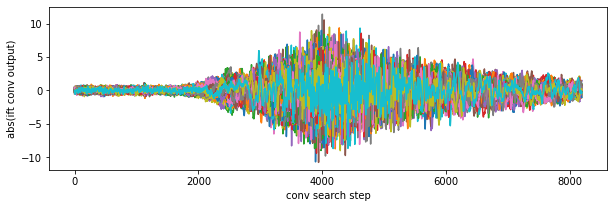

In [227]:
plt.figure(figsize=(10,3))
for i in range(100):
    plt.plot(np.real(ppt[i]))
    

width = 64
tall = 10
#plt.vlines(cycle_back.shape[0] // 2, 0, tall, color='k', linestyle='--')
#plt.vlines(cycle_back.shape[0] // 2 - width, 0, tall, color='grey', linestyle='--')
#plt.vlines(cycle_back.shape[0] // 2 + width, 0, tall, color='grey', linestyle='--')
plt.ylabel('abs(ift conv output)')
plt.xlabel('conv search step')

#plt.xlim(cycle_back.shape[0] // 2 - 1000, cycle_back.shape[0] // 2 + 1000)

In [198]:
ddddd = []
for i in range(512):
    agm = np.argmax(np.abs(ppt[i]))
    #if agm > 10000:
    #    ddddd.append(31169-agm)
    #else:
    ddddd.append(agm)

In [199]:
np.median(ddddd)

16849.0

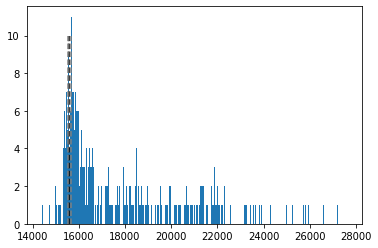

In [208]:
_ = plt.hist(ddddd, bins=500)
plt.vlines(15584, 0, 10, 'k', '--')
plt.vlines(cycle_back.shape[0] // 2 - width, 0, tall, color='grey', linestyle='--')
plt.vlines(cycle_back.shape[0] // 2 + width, 0, tall, color='grey', linestyle='--')

In [201]:
31169/2

15584.5

In [76]:

class DatasetIFTStrainFDFromSVDWFonGPU(Dataset):
    '''
    Simulate FD data in SVD-basis-convolved space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                dmin=10, dmax=200, dpower=1, loadwf=False, device='cuda',width=28, timing_std = 0.01,
                is_complex = False, add_noise=True, fix_extrinsic=False, shuffle=False, reparameterize=True):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.loadwf = loadwf
        self.device = device
        self.complex = is_complex
        self.add_noise = add_noise
        self.fix_extrinsic = fix_extrinsic
        self.shuffle = shuffle
        self.reparameterize = reparameterize
        self.width = width
        self.timing_std = timing_std
        
        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)
        
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
        
        self.shuffle_indexinfile()
            
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whiten_factor = 1/(psd*det.duration/4)**0.5
            whitened_V = (self.V.T * whiten_factor ).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64),
                                'whiten_factor': whiten_factor}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file

    def __getitem__(self, index):
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        wf_dict = self.get_precalwf_dict(index_of_file)
        hp_svd, hc_svd = self.get_waveform_tensors(wf_dict, index_in_file)

        injection_parameters = self.get_injection_parameters(wf_dict,index_in_file)
        injection_parameters = self.update_injection_parameters(injection_parameters)
        hp_svd = hp_svd/injection_parameters['luminosity_distance']
        hc_svd = hc_svd/injection_parameters['luminosity_distance']
        #x_real, x_imag = self.compute_strain_tensors(hp_svd, hc_svd, injection_parameters)

        x = self.compute_strain_tensors(hp_svd, hc_svd, injection_parameters)

        theta = self.get_theta(injection_parameters)
        #return theta, torch.cat((x_real, x_imag)).float()
        if self.complex:
            return theta, x 
        else:
            return theta, torch.cat((x.real, x.imag)).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file
        
        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors(self, wf_dict, index_in_file):
        index_in_file = self.random_index_in_file[index_in_file]
        hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index_in_file]) *\
            torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index_in_file])).type(torch.complex64)).to(self.device)
        hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index_in_file]) *\
            torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index_in_file])).type(torch.complex64)).to(self.device)
        
        return hp_svd, hc_svd

    def get_injection_parameters(self, wf_dict, index_in_file):
        index_in_file = self.random_index_in_file[index_in_file]
        injection_parameters = {key: wf_dict['injection_parameters'][key][index_in_file] for key in ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']}
        return injection_parameters

    def get_noise_tensors(self, ):
        lennoise = 2*self.width + 1
        white_noise = (torch.randn(lennoise, device=self.device) + 1j * torch.randn(lennoise, device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        #x_real = torch.zeros((num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        #x_imag = torch.zeros((num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        x = torch.zeros((num_ifos*self.Nbasis, 2*self.width + 1), dtype=torch.complex64, device=self.device)
        tc_est = injection_parameters['geocent_time'] + injection_parameters['timing_error']
        for i, det in enumerate(self.ifos):
            detname = det.name

            fp, fc, dt = self.compute_detector_factors(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = self.Vh * phase2add.unsqueeze(0)  # Ensure proper broadcasting
            
            h_full = torch.matmul((fp*hp_svd + fc*hc_svd).type(torch.complex64), Vh_recons).unsqueeze(1)
    
            cycle_back = torch.exp(2*np.pi*1j*self.farray*tc_est).unsqueeze(1)
            h_conv_fd = h_full * cycle_back * self.det_data[detname]['whitened_V'] #dataset_test.V * 

            id0 = cycle_back.shape[0] // 2
            id1 = id0 - self.width
            id2 = id0 + self.width
            h_conv_td = torch.fft.ifft(h_conv_fd.T, norm='forward').roll(id0 , dims=-1)[:,id1:id2+1]
            
            if self.add_noise:
                n_conv = self.get_noise_tensors()
                d_conv = h_conv_td + n_conv
            else:
                d_conv = h_conv_td
            
            #x_real[i] = d_conv.real
            #x_imag[i] = d_conv.imag
            x[i*self.Nbasis : (i+1)*self.Nbasis] = d_conv
        #return x_real, x_imag
        return x

    def compute_detector_factors(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        ra = injection_parameters['ra']
        dec = injection_parameters['dec']
        tc = injection_parameters['geocent_time']
        psi = injection_parameters['psi']
        fp = det.antenna_response(ra , dec, tc, psi, 'plus')
        fc = det.antenna_response(ra , dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra , dec, tc)
        
        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
            
        return fp, fc, dt

    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        else:
            parameter_names = self.parameter_names
        
        theta_list = []
        for paraname in parameter_names:
            if paraname == 'geocent_time':
                paraname = 'timing_error'
            if self.reparameterize:
                para_re = reparameterize(injection_parameters[paraname], paraname, injection_parameters)
            else:
                para_re = injection_parameters[paraname]
            theta_list.append(para_re)
        theta_array = np.array(theta_list)
        theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T
    
        return theta
    
    def update_injection_parameters(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = 1
            injection_parameters['dec'] = 1
            injection_parameters['psi'] = 1
            injection_parameters['geocent_time'] = 0
            #injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
            injection_parameters['luminosity_distance'] = 100
            injection_parameters['timing_error'] = 0
        else:
            injection_parameters['ra'] = np.random.uniform(0, 2*np.pi)
            injection_parameters['dec'] = np.arcsin(np.random.uniform(-1, 1))
            injection_parameters['psi'] = np.random.uniform(0, np.pi)
            injection_parameters['geocent_time'] = np.random.uniform(-0.1, 0.1)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
            injection_parameters['timing_error'] = np.random.randn() * self.timing_std
    
        return injection_parameters
    
    def shuffle_wflist(self):
        if self.shuffle:
            random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        if self.shuffle:
            self.random_index_in_file = np.random.permutation(self.sample_per_file)
        else:
            self.random_index_in_file = np.arange(self.sample_per_file)

In [1]:
torch.fft.ifft?

Object `torch.fft.ifft` not found.


In [87]:

class DatasetIFTStrainFDFromSVDWFonGPUBatch(Dataset):
    '''
    Simulate FD data in SVD-basis-convolved space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.

    Load a batch of data, i.e. return [minibatch_size, dim1, dim2, ...]. The batch size should be 2^N. 
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                dmin=10, dmax=200, dpower=1, loadwf=False, device='cuda',width=28, timing_std = 0.01,
                is_complex=False, add_noise=True, minibatch_size=1, fix_extrinsic=False, shuffle=True, reparameterize=True):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.loadwf = loadwf
        self.device = device
        self.minibatch_size = minibatch_size
        self.complex = is_complex
        self.add_noise = add_noise
        self.fix_extrinsic = fix_extrinsic
        self.shuffle = shuffle
        self.reparameterize = reparameterize
        self.width = width
        self.timing_std = timing_std

        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)
        
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        #if self.sample_per_file<self.minibatch_size:
        #    raise ValueError("Sample per file < batch size!")
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
            
        self.shuffle_indexinfile()
        
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whiten_factor = 1/(psd*det.duration/4)**0.5
            whitened_V = (self.V.T * whiten_factor ).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64),
                                'whiten_factor': whiten_factor}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file // self.minibatch_size

    def __getitem__(self, index):
        index = index*self.minibatch_size
        
        index_end = index + self.minibatch_size
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        index_of_file_end, index_in_file_end = self.get_index(index_end, self.sample_per_file)
        if index_of_file_end>=len(self.precalwf_filelist):
            index_of_file_end = len(self.precalwf_filelist)-1
            index_in_file_end = self.sample_per_file
        wf_dict_list = []
        for i in range(index_of_file, index_of_file_end+1):
            wf_dict_list.append(self.get_precalwf_dict(i))
        
        hp_svd, hc_svd = self.get_waveform_tensors_batch(wf_dict_list, index_in_file, index_in_file_end)
        injection_parameters = self.get_injection_parameters_batch(wf_dict_list,index_in_file, index_in_file_end)
        injection_parameters = self.update_injection_parameters_batch(injection_parameters)
        
        dL = torch.from_numpy(injection_parameters['luminosity_distance']).to(self.device).unsqueeze(-1)
        hp_svd = hp_svd/dL
        hc_svd = hc_svd/dL

        #x_real, x_imag = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)
        x = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)

        theta = self.get_theta(injection_parameters)
        if self.complex:
            return theta, x 
        else:
            return theta, torch.cat((x.real, x.imag), axis=1).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file

        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            try:
                wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            except:
                raise Exception(f'index_of_file: {index_of_file}')
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file
            if i==0:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)
            else:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)

                hp_svd = torch.cat((hp_svd,hp_svd_new))
                hc_svd = torch.cat((hc_svd,hc_svd_new))
                    
            
        return hp_svd, hc_svd

    def get_injection_parameters_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        para_name_list = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file

            index_random = self.random_index_in_file[index_in_file:end_index]
            if i==0:
                injection_parameters = {key: wf_dict['injection_parameters'][key][index_random] for key in para_name_list}
            else:
                injection_parameters = {key: np.append(injection_parameters[key], wf_dict['injection_parameters'][key][index_random]) for key in para_name_list}

        return injection_parameters

    def get_noise_tensors_batch(self, ):
        lennoise = 2*self.width + 1
        white_noise = (torch.randn((self.minibatch_size, lennoise), device=self.device) + \
                       1j * torch.randn((self.minibatch_size, lennoise), device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors_batch(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        #x_real = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        #x_imag = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        x = torch.zeros((self.minibatch_size, num_ifos*self.Nbasis, 2*self.width+1), dtype=torch.complex64, device=self.device)
        tc_est = injection_parameters['geocent_time'][0] + injection_parameters['timing_error'][0]
        for i,det in enumerate(self.ifos):
            detname = det.name
        
            fp, fc, dt = self.compute_detector_factors_batch(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = (self.Vh * phase2add.unsqueeze(0)).type(torch.complex64)  # Ensure proper broadcasting            
            
            h_full = torch.matmul((fp*hp_svd + fc*hc_svd).type(torch.complex64), Vh_recons) 
            cycle_back = torch.exp(2*np.pi*1j*self.farray*tc_est)
            #print(h_full.shape)
            #print(cycle_back.shape)
            #print(self.det_data[detname]['whitened_V'].shape)
            
            #((a * b).unsqueeze(-1) * c).shape
            
            
            h_conv_fd = (h_full * cycle_back).unsqueeze(-1) * self.det_data[detname]['whitened_V']
            #print(h_conv_fd.shape)
            h_conv_fd = h_conv_fd.movedim(1,-1)
            #print(h_conv_fd.shape)
            
            id0 = cycle_back.shape[0] // 2
            id1 = id0 - self.width
            id2 = id0 + self.width
            h_conv_td = torch.fft.ifft(h_conv_fd, norm='forward').roll(id0 , dims=-1)[:,:,id1:id2+1]
            
            if self.add_noise:
                n_conv = self.get_noise_tensors_batch()
                d_conv = h_conv_td + n_conv
            else:
                d_conv = h_conv_td
                
            
            #x_real[:,i,:] = d_conv.real
            #x_imag[:,i,:] = d_conv.imag
            #print(d_conv.shape)
            #print(x.shape)
            x[:,i*self.Nbasis : (i+1)*self.Nbasis,:] = d_conv
            #x[:,i,:] = d_conv
            
            

        return x
    
    def compute_detector_factors_batch(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        #fp_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        #fc_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        #dt_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        '''
        for i in range(len(injection_parameters['ra'])):
            
            ra = injection_parameters['ra'][i]
            dec = injection_parameters['dec'][i]
            tc = injection_parameters['geocent_time'][i]
            psi = injection_parameters['psi'][i]
            
            fp = det.antenna_response(ra, dec, tc, psi, 'plus')
            fc = det.antenna_response(ra, dec, tc, psi, 'cross')
            time_shift = det.time_delay_from_geocenter(ra, dec, tc)
            
            dt_geocent = tc #- self.strain_data.start_time
            dt = dt_geocent + time_shift
            
            fp_tensor[i] = fp
            fc_tensor[i] = fc
            dt_tensor[i] = dt
        '''
        ra = injection_parameters['ra'][0]
        dec = injection_parameters['dec'][0]
        tc = injection_parameters['geocent_time'][0]
        psi = injection_parameters['psi'][0]

        fp = det.antenna_response(ra, dec, tc, psi, 'plus')
        fc = det.antenna_response(ra, dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra, dec, tc)

        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
        
        #return fp_tensor.unsqueeze(-1), fc_tensor.unsqueeze(-1), dt_tensor.unsqueeze(-1)
        return fp, fc, dt
    
    '''
    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            reduced_parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in reduced_parameter_names]), dtype=torch.float32).to(self.device).T
        else:
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in self.parameter_names]), dtype=torch.float32).to(self.device).T
        return theta
    '''

    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        else:
            parameter_names = self.parameter_names
        
        theta_list = []
        for paraname in parameter_names:
            if paraname == 'geocent_time':
                paraname = 'timing_error'
            if self.reparameterize:
                para_re = reparameterize(injection_parameters[paraname], paraname, injection_parameters)
            else:
                para_re = injection_parameters[paraname]
            theta_list.append(para_re)
        theta_array = np.array(theta_list)
        theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T
    
        return theta
    
    def update_injection_parameters_batch(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + 0
            #injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
            injection_parameters['luminosity_distance'] = np.zeros(self.minibatch_size) + 100
            injection_parameters['timing_error'] = np.zeros(self.minibatch_size) + 0
    
        else:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + np.random.uniform(0, 2*np.pi)
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + np.arcsin(np.random.uniform(-1, 1))
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + np.random.uniform(0, np.pi)
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + np.random.uniform(-0.1, 0.1)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
            injection_parameters['timing_error'] = np.zeros(self.minibatch_size) + np.random.randn() * self.timing_std
        
        return injection_parameters
    
    def shuffle_wflist(self):
        if self.shuffle:
            random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        if self.shuffle:
            self.random_index_in_file = np.random.permutation(self.sample_per_file)
        else:
            self.random_index_in_file = np.arange(self.sample_per_file)


In [117]:
dataset = DatasetIFTStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, add_noise=False, shuffle=False, fix_extrinsic=True, width=128)

dataset_batch = DatasetIFTStrainFDFromSVDWFonGPUBatch(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, minibatch_size=20, add_noise=False, shuffle=False, fix_extrinsic=True, width=128)



In [118]:
%time theta, x = dataset[1]

CPU times: user 13.3 ms, sys: 116 µs, total: 13.4 ms
Wall time: 13.6 ms


In [119]:
%time theta_batch, x_batch = dataset_batch[0]

CPU times: user 387 ms, sys: 10.3 ms, total: 397 ms
Wall time: 202 ms


In [121]:
8e6 * 0.2 / 20 / 3600

22.22222222222222

In [102]:
theta, theta_batch[1]

(tensor([ 0.3389,  0.4605, -1.4539, -1.4134, -1.1993, -0.3965,  0.4284,  0.7802,
         -0.0776,  0.5869, -0.0175, -0.7249], device='cuda:0'),
 tensor([ 0.3389,  0.4605, -1.4539, -1.4134, -1.1993, -0.3965,  0.4284,  0.7802,
         -0.0776,  0.5869, -0.0175, -0.7249], device='cuda:0'))

In [103]:
torch.max(x - x_batch[1])

tensor(4.7684e-07, device='cuda:0')

In [19]:
a = torch.randn([500, 31169])
b = torch.randn([31169])
c = torch.randn([31169, 512])

In [16]:
(a * b).shape

torch.Size([500, 31169])

In [ ]:
(a * b).unsqueeze(-1)

In [20]:
((a * b).unsqueeze(-1) * c).shape

torch.Size([500, 31169, 512])

In [26]:
theta

tensor([-0.3251, -0.2421, -1.5789, -1.6889,  0.6401,  0.5867, -1.1906, -1.4300,
        -1.0973,  0.5890,  0.0692, -0.8918], device='cuda:0')

In [27]:
x.shape

torch.Size([3072, 129])

In [28]:
6*512

3072

# Conv

In [33]:
conv_layer_real = torch.nn.Conv1d(in_channels=1, out_channels=V.shape[1], kernel_size=V.shape[0], bias=False)
conv_layer_imag = torch.nn.Conv1d(in_channels=1, out_channels=V.shape[1], kernel_size=V.shape[0], bias=False)

conv_layer_real.weight.data[:,0,:] = torch.from_numpy(V.T.real)
conv_layer_imag.weight.data[:,0,:] = torch.from_numpy(V.T.imag)

noise_r = torch.randn((1,V.shape[0]))
noise_i = torch.randn((1,V.shape[0]))


conv_noise_r = conv_layer_real(noise_i).T.detach().numpy()
conv_noise_i = conv_layer_imag(noise_r).T.detach().numpy()
conv_noise = conv_noise_r + conv_noise_i

_ = plt.hist(noise_r, density=True, alpha=0.5, bins=50, cumulative=True)
_ = plt.hist(conv_noise[0], density=True, alpha=0.5, bins=50, cumulative=True)

In [131]:

class DatasetConvStrainFDFromSVDWFonGPU(Dataset):
    '''
    Simulate FD data in SVD-basis-convolved space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                dmin=10, dmax=200, dpower=1, loadwf=False, device='cuda',
                is_complex = False, add_noise=True, fix_extrinsic=False, shuffle=False, reparameterize=True):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.loadwf = loadwf
        self.device = device
        self.complex = is_complex
        self.add_noise = add_noise
        self.fix_extrinsic = fix_extrinsic
        self.shuffle = shuffle
        self.reparameterize = reparameterize
        
        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)

        self.conv_layer_real = torch.nn.Conv1d(in_channels=1, out_channels=self.V.shape[1],
                                               kernel_size=self.V.shape[0], bias=False).to(device)
        self.conv_layer_imag = torch.nn.Conv1d(in_channels=1, out_channels=self.V.shape[1],
                                               kernel_size=self.V.shape[0], bias=False).to(device)
        self.conv_layer_real.weight.data[:,0,:] = self.V.T.real
        self.conv_layer_imag.weight.data[:,0,:] = self.V.T.imag
        self.conv_layer_real.eval()
        self.conv_layer_imag.eval()
        
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
        
        self.shuffle_indexinfile()
            
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whiten_factor = 1/(psd*det.duration/4)**0.5
            whitened_V = (self.V.T * whiten_factor ).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64),
                                'whiten_factor': whiten_factor}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file

    def __getitem__(self, index):
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        wf_dict = self.get_precalwf_dict(index_of_file)
        hp_svd, hc_svd = self.get_waveform_tensors(wf_dict, index_in_file)

        injection_parameters = self.get_injection_parameters(wf_dict,index_in_file)
        injection_parameters = self.update_injection_parameters(injection_parameters)
        hp_svd = hp_svd/injection_parameters['luminosity_distance']
        hc_svd = hc_svd/injection_parameters['luminosity_distance']
        #x_real, x_imag = self.compute_strain_tensors(hp_svd, hc_svd, injection_parameters)
        x = self.compute_strain_tensors(hp_svd, hc_svd, injection_parameters)

        theta = self.get_theta(injection_parameters)
        #return theta, torch.cat((x_real, x_imag)).float()
        if self.complex:
            return theta, x 
        else:
            return theta, torch.cat((x.real, x.imag)).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file
        
        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors(self, wf_dict, index_in_file):
        index_in_file = self.random_index_in_file[index_in_file]
        hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index_in_file]) *\
            torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index_in_file])).type(torch.complex64)).to(self.device)
        hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index_in_file]) *\
            torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index_in_file])).type(torch.complex64)).to(self.device)
        
        return hp_svd, hc_svd

    def get_injection_parameters(self, wf_dict, index_in_file):
        index_in_file = self.random_index_in_file[index_in_file]
        injection_parameters = {key: wf_dict['injection_parameters'][key][index_in_file] for key in ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']}
        return injection_parameters

    def get_noise_tensors(self, ):
        white_noise = (torch.randn(self.Nbasis, device=self.device) + 1j * torch.randn(self.Nbasis, device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        #x_real = torch.zeros((num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        #x_imag = torch.zeros((num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        x = torch.zeros((num_ifos, self.Nbasis), dtype=torch.complex64, device=self.device)
        for i, det in enumerate(self.ifos):
            detname = det.name

            fp, fc, dt = self.compute_detector_factors(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = self.Vh * phase2add.unsqueeze(0)  # Ensure proper broadcasting
            
            h_full_whitened = torch.matmul((fp*hp_svd + fc*hc_svd).type(torch.complex64), Vh_recons) * \
                self.det_data[detname]['whiten_factor']
            
            h_full_whitened_real = h_full_whitened.real.type(torch.float).unsqueeze(0)
            h_full_whitened_imag = h_full_whitened.imag.type(torch.float).unsqueeze(0)
            h_conv_real = self.conv_layer_real(h_full_whitened_real) - self.conv_layer_imag(h_full_whitened_imag)
            h_conv_imag = self.conv_layer_real(h_full_whitened_imag) + self.conv_layer_imag(h_full_whitened_real)
            h_conv = (h_conv_real.T + 1j*h_conv_imag.T).type(torch.complex64)
            if self.add_noise:
                n_conv = self.get_noise_tensors()
                d_conv = h_conv + n_conv
            else:
                d_conv = h_conv
            
            #x_real[i] = d_conv.real
            #x_imag[i] = d_conv.imag
            x[i] = d_conv
        #return x_real, x_imag
        return x

    def compute_detector_factors(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        ra = injection_parameters['ra']
        dec = injection_parameters['dec']
        tc = injection_parameters['geocent_time']
        psi = injection_parameters['psi']
        fp = det.antenna_response(ra , dec, tc, psi, 'plus')
        fc = det.antenna_response(ra , dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra , dec, tc)
        
        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
            
        return fp, fc, dt

    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        else:
            parameter_names = self.parameter_names
        
        theta_list = []
        for paraname in parameter_names:
            if self.reparameterize:
                para_re = reparameterize(injection_parameters[paraname], paraname)
            else:
                para_re = injection_parameters[paraname]
            theta_list.append(para_re)
        theta_array = np.array(theta_list)
        theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T
    
        return theta
    
    def update_injection_parameters(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = 1
            injection_parameters['dec'] = 1
            injection_parameters['psi'] = 1
            injection_parameters['geocent_time'] = 0
            #injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
            injection_parameters['luminosity_distance'] = 100
        else:
            injection_parameters['ra'] = np.random.uniform(0, 2*np.pi)
            injection_parameters['dec'] = np.arcsin(np.random.uniform(-1, 1))
            injection_parameters['psi'] = np.random.uniform(0, np.pi)
            injection_parameters['geocent_time'] = np.random.uniform(-0.1, 0.1)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
    
        return injection_parameters
    
    def shuffle_wflist(self):
        if self.shuffle:
            random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        if self.shuffle:
            self.random_index_in_file = np.random.permutation(self.sample_per_file)
        else:
            self.random_index_in_file = np.arange(self.sample_per_file)

In [132]:

class DatasetConvStrainFDFromSVDWFonGPUBatch(Dataset):
    '''
    Simulate FD data in SVD-basis-convolved space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.

    Load a batch of data, i.e. return [minibatch_size, dim1, dim2, ...]. The batch size should be 2^N. 
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                dmin=10, dmax=200, dpower=1, loadwf=False, device='cuda',
                is_complex=False, add_noise=True, minibatch_size=1, fix_extrinsic=False, shuffle=True, reparameterize=True):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.loadwf = loadwf
        self.device = device
        self.minibatch_size = minibatch_size
        self.complex = is_complex
        self.add_noise = add_noise
        self.fix_extrinsic = fix_extrinsic
        self.shuffle = shuffle
        self.reparameterize = reparameterize

        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)
        self.conv_layer_real = torch.nn.Conv1d(in_channels=1, out_channels=self.V.shape[1],
                                               kernel_size=self.V.shape[0], bias=False).to(device)
        self.conv_layer_imag = torch.nn.Conv1d(in_channels=1, out_channels=self.V.shape[1],
                                               kernel_size=self.V.shape[0], bias=False).to(device)
        self.conv_layer_real.weight.data[:,0,:] = self.V.T.real
        self.conv_layer_imag.weight.data[:,0,:] = self.V.T.imag
        self.conv_layer_real.eval()
        self.conv_layer_imag.eval()
        
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        #if self.sample_per_file<self.minibatch_size:
        #    raise ValueError("Sample per file < batch size!")
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
            
        self.shuffle_indexinfile()
        
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whiten_factor = 1/(psd*det.duration/4)**0.5
            whitened_V = (self.V.T * whiten_factor ).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64),
                                'whiten_factor': whiten_factor}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file // self.minibatch_size

    def __getitem__(self, index):
        index = index*self.minibatch_size
        
        index_end = index + self.minibatch_size
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        index_of_file_end, index_in_file_end = self.get_index(index_end, self.sample_per_file)
        if index_of_file_end>=len(self.precalwf_filelist):
            index_of_file_end = len(self.precalwf_filelist)-1
            index_in_file_end = self.sample_per_file
        wf_dict_list = []
        for i in range(index_of_file, index_of_file_end+1):
            wf_dict_list.append(self.get_precalwf_dict(i))
        
        hp_svd, hc_svd = self.get_waveform_tensors_batch(wf_dict_list, index_in_file, index_in_file_end)
        injection_parameters = self.get_injection_parameters_batch(wf_dict_list,index_in_file, index_in_file_end)
        injection_parameters = self.update_injection_parameters_batch(injection_parameters)
        
        dL = torch.from_numpy(injection_parameters['luminosity_distance']).to(self.device).unsqueeze(-1)
        hp_svd = hp_svd/dL
        hc_svd = hc_svd/dL

        #x_real, x_imag = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)
        x = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)

        theta = self.get_theta(injection_parameters)
        if self.complex:
            return theta, x 
        else:
            return theta, torch.cat((x.real, x.imag), axis=1).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file

        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            try:
                wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            except:
                raise Exception(f'index_of_file: {index_of_file}')
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file
            if i==0:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)
            else:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)

                hp_svd = torch.cat((hp_svd,hp_svd_new))
                hc_svd = torch.cat((hc_svd,hc_svd_new))
                    
            
        return hp_svd, hc_svd

    def get_injection_parameters_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        para_name_list = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file

            index_random = self.random_index_in_file[index_in_file:end_index]
            if i==0:
                injection_parameters = {key: wf_dict['injection_parameters'][key][index_random] for key in para_name_list}
            else:
                injection_parameters = {key: np.append(injection_parameters[key], wf_dict['injection_parameters'][key][index_random]) for key in para_name_list}

        return injection_parameters

    def get_noise_tensors_batch(self, ):
        white_noise = (torch.randn((self.minibatch_size, self.Nbasis), device=self.device) + \
                       1j * torch.randn((self.minibatch_size, self.Nbasis), device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors_batch(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        #x_real = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        #x_imag = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        x = torch.zeros((self.minibatch_size, num_ifos, self.Nbasis), dtype=torch.complex64, device=self.device)
        for i,det in enumerate(self.ifos):
            detname = det.name
        
            fp, fc, dt = self.compute_detector_factors_batch(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = (self.Vh * phase2add.unsqueeze(0)).type(torch.complex64)  # Ensure proper broadcasting            
            
            h_full_whitened = torch.matmul((fp*hp_svd + fc*hc_svd).type(torch.complex64), Vh_recons) * \
                self.det_data[detname]['whiten_factor']
            
            h_full_whitened_real = h_full_whitened.real.type(torch.float).unsqueeze(1)
            h_full_whitened_imag = h_full_whitened.imag.type(torch.float).unsqueeze(1)
            h_conv_real = self.conv_layer_real(h_full_whitened_real) - self.conv_layer_imag(h_full_whitened_imag)
            h_conv_imag = self.conv_layer_real(h_full_whitened_imag) + self.conv_layer_imag(h_full_whitened_real)
            h_conv = (h_conv_real + 1j*h_conv_imag).type(torch.complex64).squeeze(-1)
            
            if self.add_noise:
                n_conv = self.get_noise_tensors_batch()
                d_conv = h_conv + n_conv
            else:
                d_conv = h_conv
                
            
            #x_real[:,i,:] = d_conv.real
            #x_imag[:,i,:] = d_conv.imag
            x[:,i,:] = d_conv
            

        return x
    
    def compute_detector_factors_batch(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        #fp_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        #fc_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        #dt_tensor = torch.zeros((self.minibatch_size), dtype=torch.float32, device=self.device)
        '''
        for i in range(len(injection_parameters['ra'])):
            
            ra = injection_parameters['ra'][i]
            dec = injection_parameters['dec'][i]
            tc = injection_parameters['geocent_time'][i]
            psi = injection_parameters['psi'][i]
            
            fp = det.antenna_response(ra, dec, tc, psi, 'plus')
            fc = det.antenna_response(ra, dec, tc, psi, 'cross')
            time_shift = det.time_delay_from_geocenter(ra, dec, tc)
            
            dt_geocent = tc #- self.strain_data.start_time
            dt = dt_geocent + time_shift
            
            fp_tensor[i] = fp
            fc_tensor[i] = fc
            dt_tensor[i] = dt
        '''
        ra = injection_parameters['ra'][0]
        dec = injection_parameters['dec'][0]
        tc = injection_parameters['geocent_time'][0]
        psi = injection_parameters['psi'][0]

        fp = det.antenna_response(ra, dec, tc, psi, 'plus')
        fc = det.antenna_response(ra, dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra, dec, tc)

        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
        
        #return fp_tensor.unsqueeze(-1), fc_tensor.unsqueeze(-1), dt_tensor.unsqueeze(-1)
        return fp, fc, dt
    
    '''
    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            reduced_parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in reduced_parameter_names]), dtype=torch.float32).to(self.device).T
        else:
            theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in self.parameter_names]), dtype=torch.float32).to(self.device).T
        return theta
    '''

    def get_theta(self, injection_parameters):
        if self.fix_extrinsic:
            parameter_names = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        else:
            parameter_names = self.parameter_names
        
        theta_list = []
        for paraname in parameter_names:
            if self.reparameterize:
                para_re = reparameterize(injection_parameters[paraname], paraname)
            else:
                para_re = injection_parameters[paraname]
            theta_list.append(para_re)
        theta_array = np.array(theta_list)
        theta = torch.tensor(theta_array, dtype=torch.float32).to(self.device).T
    
        return theta
    
    def update_injection_parameters_batch(self, injection_parameters):
        if self.fix_extrinsic:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + 1
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + 0
            #injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
            injection_parameters['luminosity_distance'] = np.zeros(self.minibatch_size) + 100
    
        else:
            injection_parameters['ra'] = np.zeros(self.minibatch_size) + np.random.uniform(0, 2*np.pi)
            injection_parameters['dec'] = np.zeros(self.minibatch_size) + np.arcsin(np.random.uniform(-1, 1))
            injection_parameters['psi'] = np.zeros(self.minibatch_size) + np.random.uniform(0, np.pi)
            injection_parameters['geocent_time'] = np.zeros(self.minibatch_size) + np.random.uniform(-0.1, 0.1)
            injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.minibatch_size, low=self.dmin, high=self.dmax, power=self.dpower)
        
        return injection_parameters
    
    def shuffle_wflist(self):
        if self.shuffle:
            random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        if self.shuffle:
            self.random_index_in_file = np.random.permutation(self.sample_per_file)
        else:
            self.random_index_in_file = np.arange(self.sample_per_file)


In [133]:
dataset = DatasetConvStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, add_noise=False, shuffle=False, fix_extrinsic=True)

dataset_batch = DatasetConvStrainFDFromSVDWFonGPUBatch(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, minibatch_size=500, add_noise=False, shuffle=False, fix_extrinsic=True)


In [134]:
%time theta, x = dataset[0]

CPU times: user 55.4 ms, sys: 2.08 ms, total: 57.4 ms
Wall time: 58.4 ms


In [135]:
%time theta_batch, x_batch = dataset_batch[0]

CPU times: user 491 ms, sys: 48 ms, total: 539 ms
Wall time: 174 ms


In [275]:
theta, theta_batch[1]

(tensor([-0.3251, -0.2421, -1.5789, -1.6889,  0.6401,  0.5867, -1.1906, -1.4300,
         -1.0973,  0.5890,  0.0692, -0.6824], device='cuda:0'),
 tensor([ 0.3389,  0.4605, -1.4539, -1.4134, -1.1993, -0.3965,  0.4284,  0.7802,
         -0.0776,  0.5869, -0.0175, -0.4958], device='cuda:0'))

In [276]:
x, x_batch[1]

(tensor([[-0.0670,  0.0084, -0.0499,  ..., -0.0570, -0.0406, -0.0272],
         [ 0.0232, -0.0033,  0.0206,  ...,  0.0018, -0.0236, -0.0045],
         [-0.1227, -0.0229,  0.0606,  ..., -0.0421,  0.0604,  0.0072],
         [-0.0372, -0.0771,  0.0075,  ...,  0.1400, -0.0491,  0.0255],
         [ 0.0153,  0.0164, -0.0039,  ...,  0.0440, -0.0154,  0.0077],
         [ 0.2213, -0.0182,  0.0938,  ..., -0.0788,  0.0204, -0.0030]],
        device='cuda:0', grad_fn=<CatBackward0>),
 tensor([[ 3.5331e-02,  9.4089e-03,  3.1641e-01,  ..., -1.1253e-01,
           5.3586e-03, -1.1718e-02],
         [ 1.6793e-02, -4.1288e-02, -5.7933e-03,  ..., -1.2214e-02,
           1.2880e-02, -1.7066e-03],
         [ 1.6186e-01, -4.6495e-01, -4.9973e-01,  ...,  4.5814e-02,
           3.1865e-02,  1.7814e-02],
         [ 1.8698e-01, -3.6249e-01, -6.4946e-03,  ...,  7.2631e-02,
          -5.9257e-02,  1.8566e-02],
         [-7.4464e-03, -6.5155e-03, -3.9691e-02,  ..., -2.8016e-02,
           1.1560e-05, -4.3498e-03]

# dot

In [122]:

class DatasetSVDStrainFDFromSVDWFonGPU(Dataset):
    '''
    Simulate FD data in SVD space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                 dmin=10, dmax=200, dpower=1, loadwf=False, loadnoise=False, device='cuda'):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.loadwf = loadwf
        self.loadnoise = loadnoise
        self.device = device

        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)

        
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
        
        self.shuffle_indexinfile()
            
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whitened_V = (self.V.T * 1/(psd*det.duration/4)**0.5).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64)}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file

    def __getitem__(self, index):
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        wf_dict = self.get_precalwf_dict(index_of_file)
        hp_svd, hc_svd = self.get_waveform_tensors(wf_dict, index_in_file)

        injection_parameters = self.get_injection_parameters(wf_dict,index_in_file)
        injection_parameters = self.update_injection_parameters(injection_parameters)
        hp_svd = hp_svd/injection_parameters['luminosity_distance']
        hc_svd = hc_svd/injection_parameters['luminosity_distance']
        x_real, x_imag = self.compute_strain_tensors(hp_svd, hc_svd, injection_parameters)

        theta = self.get_theta(injection_parameters)
        return theta, torch.cat((x_real, x_imag)).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file
        
        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors(self, wf_dict, index_in_file):
        index_in_file = self.random_index_in_file[index_in_file]
        
        hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index_in_file]) *\
            torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index_in_file])).type(torch.complex64)).to(self.device)
        hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index_in_file]) *\
            torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index_in_file])).type(torch.complex64)).to(self.device)
        
        return hp_svd, hc_svd

    def get_injection_parameters(self, wf_dict, index_in_file):
        injection_parameters = {key: wf_dict['injection_parameters'][key][index_in_file] for key in ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']}
        return injection_parameters

    def get_noise_tensors(self, ):
        white_noise = (torch.randn(self.Nbasis, device=self.device) + 1j * torch.randn(self.Nbasis, device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        x_real = torch.zeros((num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        x_imag = torch.zeros((num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        for i, det in enumerate(self.ifos):
            detname = det.name

            fp, fc, dt = self.compute_detector_factors(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = self.Vh * phase2add.unsqueeze(0)  # Ensure proper broadcasting
            h_svd = torch.matmul(torch.matmul((fp*hp_svd + fc*hc_svd).type(torch.complex64), Vh_recons),
                                 self.det_data[detname]['whitened_V'])
            #n_svd = self.get_noise_tensors()
            d_svd = h_svd #+ n_svd
            
            x_real[i] = d_svd.real
            x_imag[i] = d_svd.imag
        return x_real, x_imag

    def compute_detector_factors(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        ra = injection_parameters['ra']
        dec = injection_parameters['dec']
        tc = injection_parameters['geocent_time']
        psi = injection_parameters['psi']
        fp = det.antenna_response(ra , dec, tc, psi, 'plus')
        fc = det.antenna_response(ra , dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra , dec, tc)
        
        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
            
        return fp, fc, dt

    def get_theta(self, injection_parameters):
        #theta = torch.tensor([injection_parameters[paraname] for paraname in self.parameter_names], dtype=torch.float32).to(self.device)
        theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in self.parameter_names]), dtype=torch.float32).to(self.device)
        return theta
    
    def update_injection_parameters(self, injection_parameters):
        injection_parameters['ra'] = np.random.uniform(0, np.pi)
        injection_parameters['dec'] = np.arcsin(np.random.uniform(-1, 1))
        injection_parameters['psi'] = np.random.uniform(0, np.pi)
        injection_parameters['geocent_time'] = np.random.uniform(-0.1, 0.1)
        injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
        
        injection_parameters['ra'] = 1
        injection_parameters['dec'] = 1
        injection_parameters['psi'] = 1
        injection_parameters['geocent_time'] = 1
        injection_parameters['luminosity_distance'] = 100
    
        return injection_parameters
    
    def shuffle_wflist(self):
        random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        #self.random_index_in_file = np.random.permutation(self.sample_per_file)
        self.random_index_in_file = np.arange(self.sample_per_file)



In [123]:
np.array?

In [124]:

class DatasetSVDStrainFDFromSVDWFonGPUBatch(Dataset):
    '''
    Simulate FD data in SVD space from pre-calculated SVD waveforms, optimized for GPU or CPU computation.
    '''
    def __init__(self, precalwf_filelist, parameter_names, data_generator, Nbasis, Vhfile,
                 dmin=10, dmax=200, dpower=1, loadwf=False, loadnoise=False, device='cuda',batch_size=1):
        self.precalwf_filelist = precalwf_filelist
        self.parameter_names = parameter_names
        self.data_generator = data_generator
        self.Nbasis = Nbasis
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        self.loadwf = loadwf
        self.loadnoise = loadnoise
        self.device = device
        self.batch_size = batch_size

        # Load V and Vh matrices and convert to tensors
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.V = torch.from_numpy(self.V).to(self.device).type(torch.complex64)
        self.Vh = torch.from_numpy(self.Vh).to(self.device).type(torch.complex64)

        
        self.farray = torch.from_numpy(data_generator.frequency_array_masked).float().to(self.device)
        self.ifos = data_generator.ifos
        self.det_data = self.prepare_detector_data()
        
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        #if self.sample_per_file<self.batch_size:
        #    raise ValueError("Sample per file < batch size!")
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.cached_wf_file = testfile
        self.cached_wf_file_index = 0
            
        self.shuffle_indexinfile()
        
    def prepare_detector_data(self):
        det_data = {}
        for det in self.ifos:
            detname = det.name
            psd = det.power_spectral_density_array[self.data_generator.frequency_mask]
            psd = torch.from_numpy(psd).double().to(self.device)
            whitened_V = (self.V.T * 1/(psd*det.duration/4)**0.5).T
            det_data[detname] = {'whitened_V': whitened_V.type(torch.complex64)}
        return det_data

    def __len__(self):
        return len(self.precalwf_filelist) * self.sample_per_file // self.batch_size

    def __getitem__(self, index):
        index = index*self.batch_size
        
        index_end = index + self.batch_size
        index_of_file, index_in_file = self.get_index(index, self.sample_per_file)
        index_of_file_end, index_in_file_end = self.get_index(index_end, self.sample_per_file)
        if index_of_file_end>=len(self.precalwf_filelist):
            index_of_file_end = len(self.precalwf_filelist)-1
            index_in_file_end = self.sample_per_file
        wf_dict_list = []
        for i in range(index_of_file, index_of_file_end+1):
            wf_dict_list.append(self.get_precalwf_dict(i))
        
        hp_svd, hc_svd = self.get_waveform_tensors_batch(wf_dict_list, index_in_file, index_in_file_end)
        injection_parameters = self.get_injection_parameters_batch(wf_dict_list,index_in_file, index_in_file_end)
        injection_parameters = self.update_injection_parameters_batch(injection_parameters)
        
        dL = torch.from_numpy(injection_parameters['luminosity_distance']).to(self.device).unsqueeze(-1)
        hp_svd = hp_svd/dL
        hc_svd = hc_svd/dL

        x_real, x_imag = self.compute_strain_tensors_batch(hp_svd, hc_svd, injection_parameters)

        theta = self.get_theta(injection_parameters)
        return theta, torch.cat((x_real, x_imag), axis=1).float()

    def get_index(self, index, sample_per_file):
        index_of_file = index // sample_per_file
        index_in_file = index - index_of_file*sample_per_file

        return index_of_file, index_in_file
    
    def get_precalwf_dict(self, index_of_file):
        if self.cached_wf_file_index == index_of_file:
            return self.cached_wf_file
        else:
            try:
                wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_of_file])
            except:
                raise Exception(f'index_of_file: {index_of_file}')
            self.cached_wf_file = wf_dict
            self.cached_wf_file_index = index_of_file
            return wf_dict
        
    def get_waveform_tensors_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file
            if i==0:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)
            else:
                index = self.random_index_in_file[index_in_file:end_index]
                hp_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['plus']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['plus']['phase'][index])).type(torch.complex64)).to(self.device)
                hc_svd_new = (torch.from_numpy(wf_dict['waveform_polarizations']['cross']['amplitude'][index]) *\
                    torch.exp(1j*torch.from_numpy(wf_dict['waveform_polarizations']['cross']['phase'][index])).type(torch.complex64)).to(self.device)

                hp_svd = torch.cat((hp_svd,hp_svd_new))
                hc_svd = torch.cat((hc_svd,hc_svd_new))
                    
            
        return hp_svd, hc_svd

    def get_injection_parameters_batch(self, wf_dict_list, index_in_file, index_in_file_end):
        para_name_list = ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']
        for i, wf_dict in enumerate(wf_dict_list):
            if i==len(wf_dict_list)-1:
                end_index = index_in_file_end
            else:
                end_index = self.sample_per_file
            if i==0:
                injection_parameters = {key: wf_dict['injection_parameters'][key][index_in_file:end_index] for key in para_name_list}
            else:
                injection_parameters = {key: np.append(injection_parameters[key], wf_dict['injection_parameters'][key][index_in_file:end_index]) for key in para_name_list}

        return injection_parameters

    def get_noise_tensors_batch(self, ):
        white_noise = (torch.randn((self.batch_size, self.Nbasis), device=self.device) + \
                       1j * torch.randn((self.batch_size, self.Nbasis), device=self.device)).type(torch.complex64)

        return white_noise
    
    def compute_strain_tensors_batch(self, hp_svd, hc_svd, injection_parameters):
        num_ifos = len(self.ifos)
        x_real = torch.zeros((self.batch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        x_imag = torch.zeros((self.batch_size, num_ifos, self.Nbasis), dtype=torch.float32, device=self.device)
        
        for i,det in enumerate(self.ifos):
            detname = det.name
        
            fp, fc, dt = self.compute_detector_factors_batch(det, injection_parameters)
            phase2add = torch.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = (self.Vh * phase2add.unsqueeze(0)).type(torch.complex64)  # Ensure proper broadcasting            
            hh = (fp*hp_svd + fc*hc_svd).type(torch.complex64)

            #h_svd = torch.matmul(torch.bmm(hh.unsqueeze(1), Vh_recons).squeeze(1),
            #                     self.det_data[detname]['whitened_V'])
            h_svd = torch.matmul(torch.matmul(hh, Vh_recons),
                                 self.det_data[detname]['whitened_V'])
            
            
            
            #n_svd = self.get_noise_tensors_batch()
            d_svd = h_svd #+ n_svd
            
            x_real[:,i,:] = d_svd.real
            x_imag[:,i,:] = d_svd.imag
            

        return x_real, x_imag
    
    def compute_detector_factors_batch(self, det, injection_parameters):
        # These calculations remain on CPU as they cannot be efficiently vectorized or moved to GPU
        #fp_tensor = torch.zeros((self.batch_size), dtype=torch.float32, device=self.device)
        #fc_tensor = torch.zeros((self.batch_size), dtype=torch.float32, device=self.device)
        #dt_tensor = torch.zeros((self.batch_size), dtype=torch.float32, device=self.device)
        '''
        for i in range(len(injection_parameters['ra'])):
            
            ra = injection_parameters['ra'][i]
            dec = injection_parameters['dec'][i]
            tc = injection_parameters['geocent_time'][i]
            psi = injection_parameters['psi'][i]
            
            fp = det.antenna_response(ra, dec, tc, psi, 'plus')
            fc = det.antenna_response(ra, dec, tc, psi, 'cross')
            time_shift = det.time_delay_from_geocenter(ra, dec, tc)
            
            dt_geocent = tc #- self.strain_data.start_time
            dt = dt_geocent + time_shift
            
            fp_tensor[i] = fp
            fc_tensor[i] = fc
            dt_tensor[i] = dt
        '''
        ra = injection_parameters['ra'][0]
        dec = injection_parameters['dec'][0]
        tc = injection_parameters['geocent_time'][0]
        psi = injection_parameters['psi'][0]

        fp = det.antenna_response(ra, dec, tc, psi, 'plus')
        fc = det.antenna_response(ra, dec, tc, psi, 'cross')
        time_shift = det.time_delay_from_geocenter(ra, dec, tc)

        dt_geocent = tc #- self.strain_data.start_time
        dt = dt_geocent + time_shift
        
        #return fp_tensor.unsqueeze(-1), fc_tensor.unsqueeze(-1), dt_tensor.unsqueeze(-1)
        return fp, fc, dt
    
    def get_theta(self, injection_parameters):
        theta = torch.tensor(np.array([injection_parameters[paraname] for paraname in self.parameter_names]), dtype=torch.float32).to(self.device).T
        return theta
    
    def update_injection_parameters_batch(self, injection_parameters):
        injection_parameters['ra'] = np.zeros(self.batch_size) + np.random.uniform(0, np.pi)
        injection_parameters['dec'] = np.zeros(self.batch_size) + np.arcsin(np.random.uniform(-1, 1))
        injection_parameters['psi'] = np.zeros(self.batch_size) + np.random.uniform(0, np.pi)
        injection_parameters['geocent_time'] = np.zeros(self.batch_size) + np.random.uniform(-0.1, 0.1)
        injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=self.batch_size, low=self.dmin, high=self.dmax, power=self.dpower)
    
    
        injection_parameters['ra'] = np.zeros(self.batch_size) + 1
        injection_parameters['dec'] = np.zeros(self.batch_size) + 1
        injection_parameters['psi'] = np.zeros(self.batch_size) + 1
        injection_parameters['geocent_time'] = np.zeros(self.batch_size) + 1
        injection_parameters['luminosity_distance'] = np.zeros(self.batch_size) + 100
    
        return injection_parameters
    
    def shuffle_wflist(self):
        random.shuffle(self.precalwf_filelist)
        
    def shuffle_indexinfile(self):
        self.random_index_in_file = np.random.permutation(self.sample_per_file)
        self.random_index_in_file = np.arange(self.sample_per_file)

In [126]:
dataset = DatasetSVDStrainFDFromSVDWFonGPU(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile)

dataset_batch = DatasetSVDStrainFDFromSVDWFonGPUBatch(valid_filenames, PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY, data_generator,
                                     Nbasis=512, Vhfile=Vhfile, batch_size=500)

In [128]:
%time theta, x = dataset[1]

CPU times: user 1.84 ms, sys: 1.02 ms, total: 2.86 ms
Wall time: 3.23 ms


In [129]:
theta

tensor([ 1.7832e+00,  8.0489e-01,  8.0297e-02,  9.2001e-02,  7.5121e-01,
         1.2998e+00,  3.9186e+00,  4.5567e+00,  2.6599e+03, -9.4433e+01,
         1.5588e+00,  1.0000e+02,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         2.2423e+00,  1.0000e+00], device='cuda:0')

In [130]:
%time theta_batch, x_batch = dataset_batch[0]

CPU times: user 519 ms, sys: 25.5 ms, total: 545 ms
Wall time: 56.3 ms


In [20]:
theta_batch

tensor([[1.5416, 0.6844, 0.0442,  ..., 1.0000, 1.9039, 1.0000],
        [1.7832, 0.8049, 0.0803,  ..., 1.0000, 2.2423, 1.0000],
        [1.4724, 0.6011, 0.0868,  ..., 1.0000, 4.4845, 1.0000],
        ...,
        [1.4198, 0.5243, 0.0776,  ..., 1.0000, 1.2314, 1.0000],
        [1.9929, 0.6981, 0.0462,  ..., 1.0000, 1.3106, 1.0000],
        [1.5981, 0.5513, 0.0697,  ..., 1.0000, 1.6055, 1.0000]],
       device='cuda:0')

In [14]:
theta_batch.shape

torch.Size([64, 17])

In [234]:
theta_batch[1] == theta

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True], device='cuda:0')

In [235]:
x_batch[1] == x

tensor([[False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]], device='cuda:0')

In [236]:
torch.max(x-x_batch[1])

tensor(2.2948e-06, device='cuda:0')

In [21]:
batch_size = 3
dataloader = DataLoader(dataset_batch, batch_size=batch_size, shuffle=False)
t1 = time.time()
i=0
for theta, x in dataloader:
    i+=1
    pass
t2 = time.time()
print(t2-t1)


0.28322839736938477


In [30]:
theta.shape

torch.Size([3, 64, 17])

In [31]:
theta.view(3*64, 17)

tensor([[1.7503, 0.8116, 0.0420,  ..., 1.0000, 1.5039, 1.0000],
        [2.1065, 0.9210, 0.0243,  ..., 1.0000, 1.4091, 1.0000],
        [2.2850, 0.7723, 0.0199,  ..., 1.0000, 3.4851, 1.0000],
        ...,
        [1.6948, 0.9387, 0.0692,  ..., 1.0000, 5.9744, 1.0000],
        [1.8511, 0.8753, 0.0587,  ..., 1.0000, 3.2760, 1.0000],
        [2.0450, 0.7643, 0.0177,  ..., 1.0000, 4.0518, 1.0000]],
       device='cuda:0')

In [35]:
theta[0][1]

tensor([2.1065e+00, 9.2102e-01, 2.4294e-02, 1.8122e-02, 9.1246e-01, 2.2220e+00,
        7.4137e-01, 3.5884e-01, 3.0275e+03, 4.5719e+02, 1.3483e+00, 1.0000e+02,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.4091e+00, 1.0000e+00],
       device='cuda:0')

In [23]:
x.shape

torch.Size([3, 64, 6, 512])

In [202]:
theta_batch.shape

torch.Size([64, 17])

In [203]:
x_batch.shape

torch.Size([64, 6, 512])

In [59]:
a = torch.randn([10, 3, 512])
b = torch.randn([10, 3, 512])a


In [63]:
torch.cat((a,b), axis=1).shape

torch.Size([10, 6, 512])

In [46]:
x_batch.shape

torch.Size([6, 1, 1, 512])

In [47]:
x.shape

torch.Size([6, 512])

In [35]:
a = torch.randn([10, 512])
b = torch.randn([512, 31169])
c = torch.randn([31169, 512])

In [38]:
torch.matmul(a,b)

tensor([[-5.3440e+00,  7.6044e+00,  1.1380e+00,  ...,  3.3773e+00,
          2.2279e+00,  1.6052e+01],
        [-4.6882e+01, -9.9362e+00,  2.1260e+01,  ...,  2.2833e+00,
         -1.4698e+01, -1.2762e+01],
        [ 2.7347e+01,  9.6789e+00,  1.0008e+01,  ..., -2.8897e-02,
         -1.8365e+01, -9.7739e+00],
        ...,
        [ 3.2018e+00,  2.4542e+01, -1.4923e+01,  ...,  1.9187e+01,
         -2.9182e+01, -3.8391e+01],
        [ 1.4656e+00,  3.1817e+01,  1.7674e+00,  ...,  2.6563e+00,
         -7.1755e+00,  6.9793e+00],
        [-3.2196e+01,  7.5357e+00, -1.9396e+01,  ...,  9.5601e+00,
          1.1017e+01,  1.3944e+01]])

In [40]:
torch.matmul(a[1],b)

tensor([-46.8824,  -9.9362,  21.2602,  ...,   2.2833, -14.6982, -12.7619])

In [352]:
(sys.getsizeof(tt['injection_parameters']['a_1']) * 11 +sys.getsizeof(tt['waveform_polarizations']['cross']['amplitude'])*4)/1e6





2159.019608

In [341]:
16*32

512

In [18]:
a = torch.zeros([10, 512])

In [311]:
batch_size = 1024
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
t1 = time.time()
for theta, x in dataloader:
    pass
t2 = time.time()
print(t2-t1)


batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
t1 = time.time()
for theta, x in dataloader:
    pass
t2 = time.time()
print(t2-t1)

2.6827447414398193
2.6735222339630127


In [206]:
batch_size = 10
dataset_batch.batch_size = batch_size
t1 = time.time()
for i in range(len(dataset_batch) // batch_size):
    theta, x = dataset_batch[i*batch_size]
t2 = time.time()
print(t2-t1)



40.06834697723389


# SVD domain Verifications

In [265]:
ifos.set_strain_data_from_power_spectral_densities(sampling_frequency, duration)

In [276]:
normal_dist_samples = np.random.randn(10000)

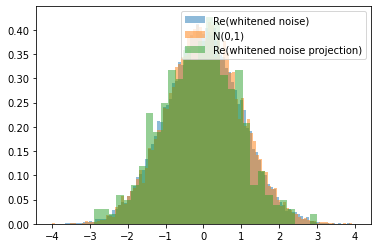

In [293]:
fmask = data_generator.frequency_mask
det = ifos[0]
#h_whitened = (det.frequency_domain_strain / det.power_spectral_density_array**0.5)[fmask]
h_whitened = det.whitened_frequency_domain_strain[fmask]
h_w_real = np.real(h_whitened)
_ = plt.hist(h_w_real, bins=100, density=True, label='Re(whitened noise)', alpha=0.5)
_ = plt.hist(normal_dist_samples, bins=100, density=True, label='N(0,1)', alpha=0.5)

h_w_real_proj = np.real(h_whitened @ V)
_ = plt.hist(h_w_real_proj, bins=30, density=True, label='Re(whitened noise projection)', alpha=0.5)

plt.legend()

In [346]:
index_precalwf_list = 0
index_wf_dict = 0
wf_dict_svd = load_dict_from_hdf5(valid_filenames[index_precalwf_list])

hp_svd = wf_dict_svd['waveform_polarizations']['plus']['amplitude'][index_wf_dict] * np.exp(1j*wf_dict_svd['waveform_polarizations']['plus']['phase'][index_wf_dict])
hc_svd = wf_dict_svd['waveform_polarizations']['cross']['amplitude'][index_wf_dict] * np.exp(1j*wf_dict_svd['waveform_polarizations']['cross']['phase'][index_wf_dict])

dL = 100
ra = dec = tc = psi = 1

hp_svd /= dL
hc_svd /= dL

injection_parameters = {key: wf_dict_svd['injection_parameters'][key][index_wf_dict] for key in \
                        ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']}
injection_parameters['ra'] = ra
injection_parameters['dec'] = dec
injection_parameters['psi'] = psi
injection_parameters['geocent_time'] = tc
injection_parameters['luminosity_distance'] = dL

fp = det.antenna_response(ra, dec, tc, psi, 'plus')
fc = det.antenna_response(ra, dec, tc, psi, 'cross')

time_shift = det.time_delay_from_geocenter(ra, dec, tc)
dt_geocent = tc #- self.strain_data.start_time
dt = dt_geocent + time_shift
#t1 = time.time()

phase2add = np.exp(-1j * 2 * np.pi * dt * data_generator.frequency_array_masked)
Vh_recons = Vh * phase2add

psd = det.power_spectral_density_array[data_generator.frequency_mask]
whitened_V = (V.T * 1/ (psd*det.duration/4)**0.5).T
h_svd = (fp*hp_svd + fc*hc_svd) @ Vh_recons @ whitened_V




In [347]:
m1, m2 = bilby.gw.conversion.chirp_mass_and_mass_ratio_to_component_masses(injection_parameters['chirp_mass'],
                                                                          injection_parameters['mass_ratio'])

lambda_1, lambda_2 = bilby.gw.conversion.lambda_tilde_delta_lambda_tilde_to_lambda_1_lambda_2(injection_parameters['lambda_tilde'],
                                                                        injection_parameters['delta_lambda_tilde'],
                                                                        m1,
                                                                        m2)

injection_parameters['lambda_1'] = lambda_1
injection_parameters['lambda_2'] = lambda_2

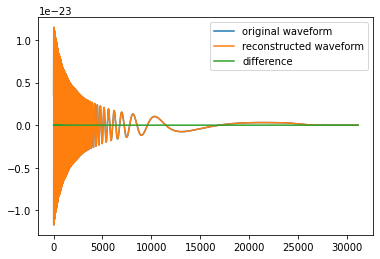

In [371]:
hp_truth = wf_dict['plus'][fmask]
hp_recons = hp_svd @ Vh
plt.plot(hp_truth.real, label='original waveform')
plt.plot(hp_recons.real, label='reconstructed waveform')
plt.plot(hp_truth.real-hp_recons.real, label='difference')

plt.legend()

In [372]:
max(abs(hp_truth - hp_recons))

3.1575528312829734e-26

In [351]:
wf_dict = data_generator.waveform_generator.frequency_domain_strain(injection_parameters)

det.set_strain_data_from_zero_noise(sampling_frequency, duration)
det.inject_signal_from_waveform_polarizations(injection_parameters, wf_dict)

h = det.whitened_frequency_domain_strain[fmask]

h_svd_real = h @ V

00:30 bilby INFO    : Injected signal in H1:
00:30 bilby INFO    :   optimal SNR = 24.43
00:30 bilby INFO    :   matched filter SNR = 24.43+0.00j
00:30 bilby INFO    :   chirp_mass = 2.339856324862661
00:30 bilby INFO    :   mass_ratio = 0.8659708049623089
00:30 bilby INFO    :   a_1 = 0.06216265691592298
00:30 bilby INFO    :   a_2 = 0.08914437404150997
00:30 bilby INFO    :   tilt_1 = 2.3507788841927697
00:30 bilby INFO    :   tilt_2 = 1.3318154911800926
00:30 bilby INFO    :   phi_12 = 3.4831157801287085
00:30 bilby INFO    :   phi_jl = 6.081169020095412
00:30 bilby INFO    :   lambda_tilde = 1013.0015645265875
00:30 bilby INFO    :   delta_lambda_tilde = 377.3961862433125
00:30 bilby INFO    :   theta_jn = 0.8202826654464147
00:30 bilby INFO    :   phase = 4.781759838461271
00:30 bilby INFO    :   ra = 1
00:30 bilby INFO    :   dec = 1
00:30 bilby INFO    :   psi = 1
00:30 bilby INFO    :   geocent_time = 1
00:30 bilby INFO    :   luminosity_distance = 100
00:30 bilby INFO    :   l

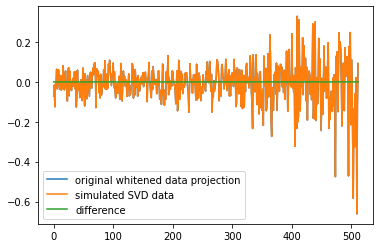

In [357]:
plt.plot(h_svd_real.real, label='original whitened data projection')
plt.plot(h_svd.real, label='simulated SVD data')
plt.plot(h_svd.real-h_svd_real.real, label='difference')

plt.legend()

In [373]:
max(abs(h_svd_real - h_svd))

0.0010954262972695768

# archived

In [7]:
precalnoise_filelistdict = {}
precalnoise_filelistdict['H1'] = noise_filenames_H1[:10]
precalnoise_filelistdict['L1'] = noise_filenames_L1[:10]
precalnoise_filelistdict['V1'] = noise_filenames_V1[:10]

In [186]:
class DatasetSVDStrainFDFromSVDWF(Dataset):
    '''
    Simulate FD data in SVD space from pre-calculated SVD waveforms. 
    '''
    def __init__(self, precalwf_filelist, precalnoise_filelistdict, parameter_names, data_generator, Nbasis, Vhfile,
                 dmin=10, dmax=200, dpower=1, loadwf = False, loadnoise=False):
        #self.farray = torch.from_numpy(data_dict['farray']).float()

        # load waveform
        self.precalwf_filelist = precalwf_filelist
        testfile = load_dict_from_hdf5(precalwf_filelist[0])
        self.sample_per_file = len(testfile['injection_parameters']['chirp_mass'])
        self.Nfile = len(self.precalwf_filelist)
        self.Nsample = self.Nfile * self.sample_per_file 
        self.loadwf = loadwf
        if loadwf:
            self.precalwf_list = []
            for file in self.precalwf_filelist:
                self.precalwf_list.append(load_dict_from_hdf5(file))
        
        # load noise
        self.precalnoise_filelistdict = precalnoise_filelistdict
        self.precalnoise_listdict = {}
        for detname, precalnoise_filelist in precalnoise_filelistdict.items():
            testfile = load_model(precalnoise_filelist[0])
            self.noise_per_file = len(testfile)
            self.Nnoisefile = len(precalnoise_filelist)
            self.Nnoise = self.Nnoisefile * self.noise_per_file
            self.loadnoise = loadnoise
            if loadnoise:
                print('loading precal noise')
                self.precalnoise_listdict[detname] = []
                for file in precalnoise_filelist:
                    self.precalnoise_listdict[detname].append(load_model(file))
        
        self.dmin = dmin
        self.dmax = dmax
        self.dpower = dpower
        
        self.parameter_names = parameter_names
        self.paradim = len(parameter_names)
        self.data_generator = data_generator
        self.detector_names = data_generator.detector_names
        self.ifos = data_generator.ifos
        #self.ipca_gen = ipca_gen
        self.V, self.Vh = loadVandVh(Vhfile, Nbasis)
        self.Nbasis = Nbasis
        self.farray = data_generator.frequency_array_masked
        
        #print('getting Vs')
        self.det_data = {}
        for det in self.ifos:
            detname = det.name
            self.det_data[detname] = {}
            psd = det.power_spectral_density_array[data_generator.frequency_mask]
            self.det_data[detname]['PSD'] = psd
            self.det_data[detname]['whitened_V'] = (self.V.T * 1/psd**0.5).T
            #self.det_data[detname]['whitened_V'] = np.diag(1e-23/psd**0.5) @ self.V
            #det_data[detname]['PSD_SVD'] = psd @ self.V
            
    def __len__(self):
        return self.Nsample

    def __getitem__(self, index):
        #t1 = time.time()
        index_precalwf_list, index_wf_dict = self.get_wf_index(index)
        
        if self.loadwf:
            wf_dict = self.precalwf_list[index_precalwf_list]
        else:
            wf_dict = load_dict_from_hdf5(self.precalwf_filelist[index_precalwf_list])

        hp_svd = wf_dict['waveform_polarizations']['plus']['amplitude'][index_wf_dict] * np.exp(1j*wf_dict['waveform_polarizations']['plus']['phase'][index_wf_dict])
        hc_svd = wf_dict['waveform_polarizations']['cross']['amplitude'][index_wf_dict] * np.exp(1j*wf_dict['waveform_polarizations']['cross']['phase'][index_wf_dict])
        
        #t2 = time.time()
        
        #print(f"read hp hc: {t2-t1}")
        injection_parameters = {}
        for key in ['chirp_mass', 'mass_ratio', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
                    'lambda_tilde', 'delta_lambda_tilde', 'theta_jn', 'phase']: # 12-D intrinsic para
            injection_parameters[key] = wf_dict['injection_parameters'][key][index_wf_dict]
        
        injection_parameters = self.update_injection_parameters(injection_parameters)
        dL = injection_parameters['luminosity_distance']
        ra = injection_parameters['ra']
        dec = injection_parameters['dec']
        psi = injection_parameters['psi']
        tc = injection_parameters['geocent_time']
        
        hp_svd /= dL
        hc_svd /= dL
        
        x_real = []
        x_imag = []
        for det in self.ifos:
            
            fp = det.antenna_response(ra, dec, tc, psi, 'plus')
            fc = det.antenna_response(ra, dec, tc, psi, 'cross')
            
            time_shift = det.time_delay_from_geocenter(ra, dec, tc)
            dt_geocent = tc #- self.strain_data.start_time
            dt = dt_geocent + time_shift
            #t1 = time.time()
            
            phase2add = np.exp(-1j * 2 * np.pi * dt * self.farray)
            Vh_recons = self.Vh * phase2add
            
            #h_torch = torch.from_numpy(fp*hp_svd + fc*hc_svd)
            #Vhrecon_torch = torch.from_numpy(Vh_recons)
            h_svd = (fp*hp_svd + fc*hc_svd) @ Vh_recons @ self.det_data[det.name]['whitened_V']
            
            #t2 = time.time()
            #noise_index = np.random.randint(0, self.Nnoise)
            noise_index = 10
            noisefile_index = noise_index // self.noise_per_file
            noise_index_infile = noise_index - noisefile_index*self.noise_per_file
            
            if self.loadnoise:
                n_svd = self.precalnoise_listdict[det.name][noisefile_index][noise_index_infile]
            else:
                n_svd = load_model(self.precalnoise_filelistdict[det.name][index_precalwf_list])[noise_index_infile]
                
            #t3 = time.time()
            
            #print(f"get phase: {t2-t1}")
            #print(f"get n: {t3-t2}")
            d_svd = h_svd + n_svd
            x_real.append(np.real(d_svd))
            x_imag.append(np.imag(d_svd))
            
        x_real = torch.from_numpy(np.array(x_real))
        x_imag = torch.from_numpy(np.array(x_imag))
        
        x = torch.cat((x_real, x_imag)).float()
        theta = self.get_theta(injection_parameters)

        #return theta.clone().detach(), strain.clone().detach(), inv_asd.clone().detach()
        return theta.clone().detach(), x.squeeze(0).clone().detach()

    def get_wf_index(self, index):
        index_precalwf_list = index // self.sample_per_file
        index_wf_dict = index - index_precalwf_list*self.sample_per_file

        return index_precalwf_list, index_wf_dict

    #def update_injection_parameters(self, injection_parameters):
    #    injection_parameters['ra'] = np.random.uniform(0, np.pi)
    #    injection_parameters['dec'] = np.arcsin(np.random.uniform(-1, 1))
    #    injection_parameters['psi'] = np.random.uniform(0, np.pi)
    #    injection_parameters['geocent_time'] = np.random.uniform(-0.1, 0.1)
    #    injection_parameters['luminosity_distance'] = generate_random_distance(Nsample=1, low=self.dmin, high=self.dmax, power=self.dpower)[0]
    #
    #   return injection_parameters
    
    def update_injection_parameters(self, injection_parameters):
        injection_parameters['ra'] = 1
        injection_parameters['dec'] = 1
        injection_parameters['psi'] = 1
        injection_parameters['geocent_time'] = 1
        injection_parameters['luminosity_distance'] = 100

        return injection_parameters
   
    def get_theta(self, injection_parameters):
        theta = []
        for paraname in self.parameter_names:
            tt = injection_parameters[paraname]
            #if paraname in ['chirp_mass']:
            #    theta.append(reparameterize_mass(tt))
            #else:
            #    theta.append(tt)
            theta.append(tt)
        
        return torch.from_numpy(np.array(theta)).float()

    def _project_strain_data_FDAPhi(self, strain, psd, detector_names, ipca_gen, project=True, downsample_rate=1, dim=1):
        '''
        strain: DatasetStrainFD in batches, e.g. DatasetStrainFD[0:10]
        psd: strain-like
        detector_names: DatasetStrainFD.detector_names
        ipca_gen: IPCAGenerator
        '''
        strain = np.expand_dims(strain, 0)
        psd = np.expand_dims(psd, 0)
        strain_amp = np.abs(strain)
        strain_phi = np.unwrap(np.angle(strain) , axis=-1)
        strain_real = np.real(strain)
        strain_imag = np.imag(strain)

        n_components = ipca_gen.n_components
        batch_size = strain.shape[0]
        ndet = len(detector_names)

        output_amp = []
        output_phi = []
        output_psd = []
        for i,detname in enumerate(detector_names):
            if project:
                output_amp.append(ipca_gen.project(strain_amp[:,i,:], detname, 'amplitude'))
                output_phi.append(ipca_gen.project(strain_phi[:,i,:], detname, 'phase'))
                output_psd.append(ipca_gen.project(psd[:,i,:], detname, 'amplitude'))
            else:
                output_amp.append(strain_amp.numpy()[:,i,:][:,::downsample_rate])
                output_phi.append(strain_phi[:,i,:][:,::downsample_rate])
                #output_amp.append(strain_real.numpy()[:,i,:][:,::downsample_rate])
                #output_phi.append(strain_imag.numpy()[:,i,:][:,::downsample_rate])
                output_psd.append(psd.numpy()[:,i,:][:,::downsample_rate])

        output_amp = torch.from_numpy(np.array(output_amp))
        output_phi = torch.from_numpy(np.array(output_phi))
        output_psd = torch.from_numpy(np.array(output_psd))
        data_length = output_amp.shape[-1]
        if dim==1:
            return torch.cat((output_amp, output_phi, output_psd)).movedim(0,1).float()
        elif dim==2:
            return torch.cat((output_amp, output_phi, output_psd)).movedim(0,1).float().view((batch_size,3,ndet,data_length))

In [187]:
testds = DatasetSVDStrainFDFromSVDWF(precalwf_filelist=valid_filenames[:2],
                                     precalnoise_filelistdict=precalnoise_filelistdict,
                                     parameter_names=PARAMETER_NAMES_CONTEXT_PRECESSINGBNS_BILBY,
                                     data_generator=data_generator,
                                     Nbasis=512,
                                     Vhfile="/home/qian.hu/mlpe/river/test/outputs/Vh_50Hz1024Hz32s.pickle",
                                     dmin=10, dmax=200, dpower=1, loadwf = False, loadnoise=False)

In [188]:
%time theta, x = testds[2]

CPU times: user 1.54 s, sys: 6.96 s, total: 8.49 s
Wall time: 189 ms


In [189]:
x

tensor([[ 0.4115,  1.0161, -1.3963,  ...,  0.6798,  2.3966, -0.7424],
        [-0.5347, -1.0312,  1.5108,  ..., -0.6503, -2.2797,  0.7021],
        [ 1.0960,  1.0947, -3.1980,  ...,  0.3458,  1.4852, -1.1084],
        [ 0.8158,  0.6372, -2.5954,  ...,  0.1554,  0.6644, -0.8165],
        [-0.7790, -0.6258,  2.3287,  ..., -0.1534, -0.6515,  0.7853],
        [-0.3911, -0.9349,  1.0289,  ..., -0.6943, -2.2874,  0.5154]])

In [35]:
testloader = DataLoader(testds, batch_size=10, shuffle=True, num_workers=1)